In [209]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools

In [210]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Sopprimi i RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [211]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [212]:
# dati = pd.read_csv('Bitcoin (€) da yfinance dal 06-05-2022 alle 21 al 05-05-2024 alle 19 con granularità oraria.csv')
# dati = dati[['Datetime', 'Close']]
# dati = dati.rename(columns = {'Datetime':'Timestamp', 'Close': 'Price'})
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
# dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d %H')
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d %H')
# dati

In [213]:
data_inizio = '2020-02-29'
data_fine = '2020-09-01'
indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2020-02-29,7798.025879
1,2020-03-01,7748.164551
2,2020-03-02,7959.358398
3,2020-03-03,7862.485352
4,2020-03-04,7861.055176
...,...,...
181,2020-08-28,9695.468750
182,2020-08-29,9664.351562
183,2020-08-30,9824.922852
184,2020-08-31,9785.023438


In [214]:
# data_inizio = '2023-06-01 00'
# data_fine = '2023-12-01 00'
# indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
# indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
# dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
# dati

### Eventuale cambio dati

In [215]:
def calcola_prezzo(t):
    return dati['Price'][t] #1000 - t + 100 * math.sin(2*math.pi * t / 4)

In [216]:
dati['Price'] = dati.index.map(calcola_prezzo)
dati

,Timestamp,Price
0,2020-02-29,7798.025879
1,2020-03-01,7748.164551
2,2020-03-02,7959.358398
3,2020-03-03,7862.485352
4,2020-03-04,7861.055176
...,...,...
181,2020-08-28,9695.468750
182,2020-08-29,9664.351562
183,2020-08-30,9824.922852
184,2020-08-31,9785.023438


In [217]:
def trading_strategy(dati, perc_acquisto, perc_vendita, liquidita_iniziale, bitcoin_iniziali, soglia_vendita):
    transazioni = []
    liquidita = liquidita_iniziale
    bitcoin = bitcoin_iniziali
    ultima_azione = '-'
    ultimo_prezzo_acquisto = None
    
    for i in range(1, len(dati)):
        data = dati['Timestamp'][i]
        prezzo_oggi = dati['Price'][i]
        prezzo_ieri = dati['Price'][i-1]
        
        liquidita_precedente = liquidita
        bitcoin_precedenti = bitcoin
        
        if prezzo_oggi < prezzo_ieri:
            # Acquisto
            quantita_euro = liquidita * perc_acquisto
            quantita_bitcoin = quantita_euro / prezzo_oggi
            liquidita -= quantita_euro
            bitcoin += quantita_bitcoin
            if quantita_euro != 0:
                azione = 'Acquisto'
                ultima_azione = azione
                ultimo_prezzo_acquisto = prezzo_oggi
            else:
                azione = '-'
        elif prezzo_oggi > prezzo_ieri:
            # Vendita
            if prezzo_oggi > ultimo_prezzo_acquisto * (1 + soglia_vendita):
                quantita_bitcoin = bitcoin * perc_vendita
                quantita_euro = quantita_bitcoin * prezzo_oggi
                liquidita += quantita_euro
                bitcoin -= quantita_bitcoin
                if quantita_bitcoin != 0:
                    azione = 'Vendita'
                    ultima_azione = azione
            else:
                azione = '-'
        else:
            # Nessuna azione
            quantita_euro = 0
            quantita_bitcoin = 0
            azione = '-'
        
        valore_totale = liquidita + bitcoin * prezzo_oggi
        
        transazioni.append({
            'data': data,
            'prezzo': prezzo_oggi,
            'azione': azione,
            'ultima_azione': ultima_azione,
            'percentuale_liquidità_usata': round((quantita_euro / liquidita_precedente), 2) if azione == "Acquisto" and liquidita_precedente != 0 else 0,
            'percentuale_token_venduti': round((quantita_bitcoin / bitcoin_precedenti), 2) if azione == "Vendita" and bitcoin_precedenti != 0 else 0,
            'quantità_euro': round(quantita_euro, 2),
            'quantità_bitcoin': round(quantita_bitcoin, 6),
            'liquidità_posseduta': round(liquidita, 2),
            'bitcoin_posseduti': round(bitcoin, 6),
            'valore_totale_portafoglio': valore_totale
        })
        
        ultima_azione = azione
    
    return pd.DataFrame(transazioni)

In [218]:
liquidita_iniziale = 1000
bitcoin_iniziali = 0
perc_acquisto = 1
perc_vendita = 1
soglia_vendita = -0.2

df_transazioni = trading_strategy(dati, perc_acquisto, perc_vendita, liquidita_iniziale, bitcoin_iniziali, soglia_vendita)
df_transazioni

,data,prezzo,azione,ultima_azione,percentuale_liquidità_usata,percentuale_token_venduti,quantità_euro,quantità_bitcoin,liquidità_posseduta,bitcoin_posseduti,valore_totale_portafoglio
0,2020-03-01,7748.164551,Acquisto,Acquisto,1.0,0.0,1000.00,0.129063,0.00,0.129063,1000.000000
1,2020-03-02,7959.358398,Vendita,Vendita,0.0,1.0,1027.26,0.129063,1027.26,0.000000,1027.257274
2,2020-03-03,7862.485352,Acquisto,Acquisto,1.0,0.0,1027.26,0.130653,0.00,0.130653,1027.257274
3,2020-03-04,7861.055176,-,Acquisto,0.0,0.0,0.00,0.000000,0.00,0.130653,1027.070418
4,2020-03-05,8089.786133,Vendita,Vendita,0.0,1.0,1056.95,0.130653,1056.95,0.000000,1056.954803
...,...,...,...,...,...,...,...,...,...,...,...
180,2020-08-28,9695.468750,Vendita,Vendita,0.0,1.0,1593.57,0.164363,1593.57,0.000000,1593.574295
181,2020-08-29,9664.351562,Acquisto,Acquisto,1.0,0.0,1593.57,0.164892,0.00,0.164892,1593.574295
182,2020-08-30,9824.922852,Vendita,Vendita,0.0,1.0,1620.05,0.164892,1620.05,0.000000,1620.051216
183,2020-08-31,9785.023438,Acquisto,Acquisto,1.0,0.0,1620.05,0.165564,0.00,0.165564,1620.051216


In [219]:
df_transazioni['valore_totale_portafoglio'].diff()

0            NaN
1      27.257274
2       0.000000
3      -0.186857
4      29.884385
         ...    
180    18.801723
181     0.000000
182    26.476922
183     0.000000
184    41.977196
Name: valore_totale_portafoglio, Length: 185, dtype: float64

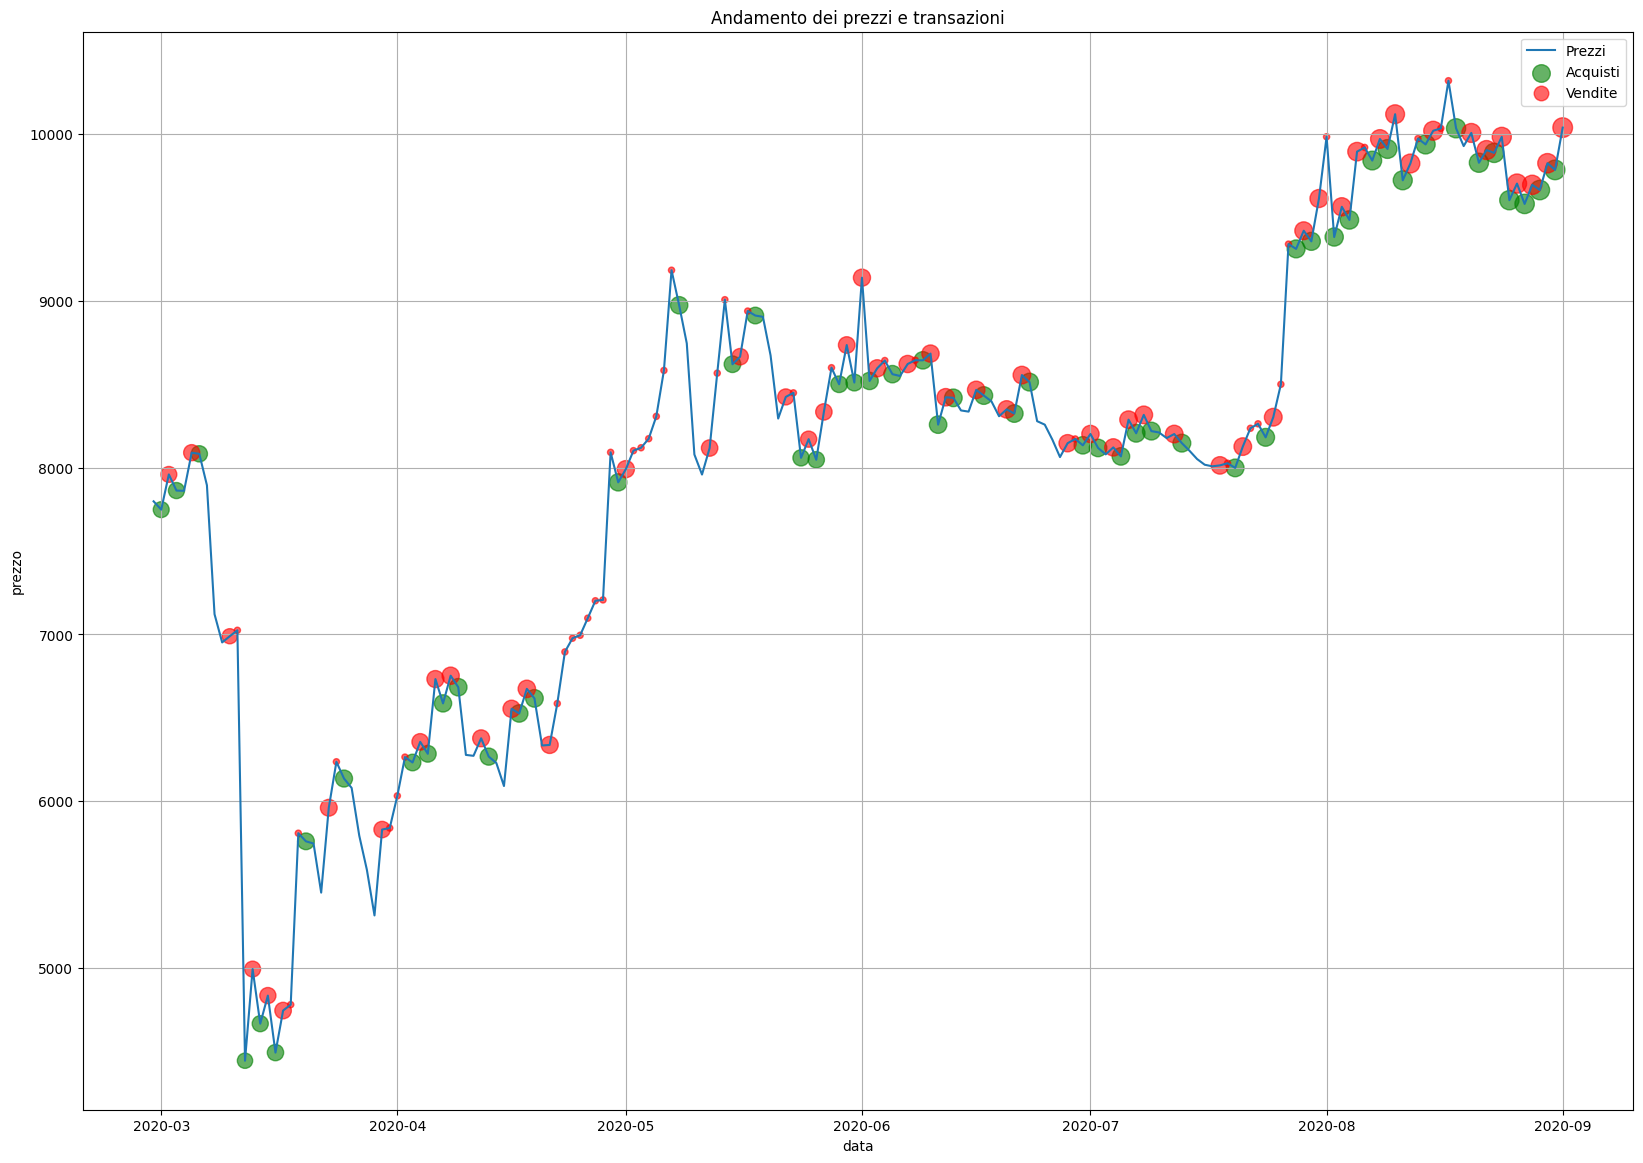

In [220]:
etichette = False

# Preparazione dei dati per il grafico
acquisti = df_transazioni[df_transazioni['azione'].isin(['Acquisto'])]
vendite = df_transazioni[df_transazioni['azione'].isin(['Vendita'])]

# Calcolo delle dimensioni dei punti
max_acquisto = acquisti['quantità_euro'].max()
max_vendita = vendite['quantità_euro'].max()

def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
    return min_size + (max_size - min_size) * (quantita / max_quantita)

dimensioni_acquisti = acquisti['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_acquisto))
dimensioni_vendite = vendite['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_vendita))

# Creazione del grafico
plt.figure(figsize=(20, 14))
plt.grid()
plt.plot(dati['Timestamp'], dati['Price'], label='Prezzi')
if not acquisti.empty:
    plt.scatter(acquisti['data'], acquisti['prezzo'], s=dimensioni_acquisti, color='green', alpha=0.6, label='Acquisti')
    if etichette:
        for i, row in acquisti.iterrows():
            plt.text(row['data'], row['prezzo'], f"+{row['quantità_euro']:.2f} €", 
                     color='black', ha='center', va='bottom')
if not vendite.empty:
    plt.scatter(vendite['data'], vendite['prezzo'], s=dimensioni_vendite, color='red', alpha=0.6, label='Vendite')
    if etichette:
        for i, row in vendite.iterrows():
            plt.text(row['data'], row['prezzo'], f"-{row['quantità_euro']:.2f} €", 
                     color='black', ha='center', va='top')

plt.xlabel('data')
plt.ylabel('prezzo')
plt.title('Andamento dei prezzi e transazioni')
plt.legend()
plt.show()

In [221]:
def calcola_rendimento_portafoglio_ideale(capitale_iniziale, bitcoin_iniziali, lista_prezzi, min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita):
    capitale = capitale_iniziale
    bitcoin = bitcoin_iniziali
    comprato = False

    for i in range(len(lista_prezzi) - 1):
        # Compra al minimo
        if lista_prezzi[i] < lista_prezzi[i + 1] and not comprato and capitale >= min_acquisto:
            bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / lista_prezzi[i]
            bitcoin += bitcoin_acquistati
            capitale = 0
            comprato = True
            # print(f'Bitcoin posseduti: {bitcoin}')
        # Vende al massimo
        elif lista_prezzi[i] > lista_prezzi[i + 1] and comprato and bitcoin * lista_prezzi[i] >= min_vendita:
            capitale_vendita = bitcoin * lista_prezzi[i] * (1 - perc_commissione_vendita)
            capitale += capitale_vendita
            bitcoin = 0
            comprato = False
            # print(f'Capitale posseduto: {capitale}')

    # Vende i bitcoin rimasti all'ultimo prezzo
    if comprato and bitcoin * lista_prezzi.iloc[-1] >= min_vendita:
        capitale += bitcoin * lista_prezzi.iloc[-1] * (1 - perc_commissione_vendita)
        bitcoin = 0
        # print(f'Capitale posseduto: {capitale}')
        # print(f'Bitcoin posseduti: {bitcoin}')

    valore_iniziale = capitale_iniziale + bitcoin_iniziali * lista_prezzi[0]
    valore_finale = capitale + bitcoin * lista_prezzi.iloc[-1]

    rendimento = valore_finale / valore_iniziale

    return [rendimento, valore_finale]

In [222]:
rendimento_ideale, portafoglio_finale_ideale = calcola_rendimento_portafoglio_ideale(liquidita_iniziale, bitcoin_iniziali, dati['Price'], 0, 0, 0, 0)
print('Rendimento ideale:', rendimento_ideale)
print('Portafoglio finale ideale in euro:', portafoglio_finale_ideale)

Rendimento ideale: 11.157643238313565
Portafoglio finale ideale in euro: 11157.643238313565


In [223]:
valore_iniziale = df_transazioni['valore_totale_portafoglio'].iloc[0]
valore_finale = df_transazioni['valore_totale_portafoglio'].iloc[-1]
rendimento = valore_finale / valore_iniziale

In [224]:
print(f"Rendimento del portafoglio: {rendimento}")
print(f'Punteggio rendimento: {round(rendimento / rendimento_ideale *100, 2)}%')
print(f"Valore finale del portafoglio in euro: {df_transazioni['valore_totale_portafoglio'].iloc[-1]}")

Rendimento del portafoglio: 1.6620284126845613
Punteggio rendimento: 14.9%
Valore finale del portafoglio in euro: 1662.028412684561


In [226]:
# Colonna per tracciare il valore delle transazioni (profitto o perdita)
df_transazioni['transaction_value'] = 0.0

# Variabili per tracciare l'acquisto totale accumulato
total_quantity = 0  # Quantità complessiva acquistata
total_cost = 0  # Costo totale di acquisto

# Ciclo per aggiornare la colonna transaction_value
for i, row in df_transazioni.iterrows():
    if row['azione'] == 'Acquisto':
        # Accumula gli acquisti: aggiorna il costo totale e la quantità
        total_quantity += row['quantità_euro']
        total_cost += row['quantità_euro'] * row['prezzo']
    
    elif row['azione'] == 'Vendita':
        if total_quantity == 0:
            raise ValueError("Stai vendendo senza aver comprato nulla!")
        
        # Calcola il prezzo medio d'acquisto
        avg_Acquistorice = total_cost / total_quantity
        
        # Calcola il valore della vendita rispetto all'acquisto
        sale_value = row['quantità_euro'] * row['prezzo']
        purchase_cost = row['quantità_euro'] * avg_Acquistorice
        
        # Calcola il profitto/perdita per questa vendita
        profit_or_loss = sale_value - purchase_cost
        
        # Aggiorna la colonna transaction_value
        df_transazioni.at[i, 'transaction_value'] = profit_or_loss
        
        # Riduci la quantità e il costo totale in base a quanto hai venduto
        total_quantity -= row['quantità_euro']
        total_cost -= purchase_cost

# Mostra il DataFrame con il transaction_value
df_transazioni

,data,prezzo,azione,ultima_azione,percentuale_liquidità_usata,percentuale_token_venduti,quantità_euro,quantità_bitcoin,liquidità_posseduta,bitcoin_posseduti,valore_totale_portafoglio,transaction_value
0,2020-03-01,7748.164551,Acquisto,Acquisto,1.0,0.0,1000.00,0.129063,0.00,0.129063,1000.000000,0.000000
1,2020-03-02,7959.358398,Vendita,Vendita,0.0,1.0,1027.26,0.129063,1027.26,0.000000,1027.257274,216950.991943
2,2020-03-03,7862.485352,Acquisto,Acquisto,1.0,0.0,1027.26,0.130653,0.00,0.130653,1027.257274,0.000000
3,2020-03-04,7861.055176,-,Acquisto,0.0,0.0,0.00,0.000000,0.00,0.130653,1027.070418,0.000000
4,2020-03-05,8089.786133,Vendita,Vendita,0.0,1.0,1056.95,0.130653,1056.95,0.000000,1056.954803,236951.697585
...,...,...,...,...,...,...,...,...,...,...,...,...
180,2020-08-28,9695.468750,Vendita,Vendita,0.0,1.0,1593.57,0.164363,1593.57,0.000000,1593.574295,15037.747867
181,2020-08-29,9664.351562,Acquisto,Acquisto,1.0,0.0,1593.57,0.164892,0.00,0.164892,1593.574295,0.000000
182,2020-08-30,9824.922852,Vendita,Vendita,0.0,1.0,1620.05,0.164892,1620.05,0.000000,1620.051216,280981.934675
183,2020-08-31,9785.023438,Acquisto,Acquisto,1.0,0.0,1620.05,0.165564,0.00,0.165564,1620.051216,0.000000


In [232]:
def trading_statistics(df, commission_per_trade=0, financial_costs=0):
    """
    Calcola le statistiche di trading da un DataFrame di operazioni, includendo profitto/perdita e commissioni.
    
    Parametri:
    - df (DataFrame): Un DataFrame contenente almeno una colonna 'transaction_value' con i profitti o le perdite.
    - commission_per_trade (float): Commissione fissa per operazione (default: 0).
    - financial_costs (float): Costi finanziari aggiuntivi da includere (default: 0).

    Restituisce:
    - DataFrame con le statistiche di trading.
    """

    pd.set_option('display.float_format', '{:.2f}'.format) # Per evitare la notazione scientifica
    
    # Assumi che la colonna 'transaction_value' contenga i profitti e le perdite
    total_net_pnl = df['transaction_value'].sum()

    net_profit = df[df['transaction_value'] > 0]['transaction_value'].sum()
    net_loss = df[df['transaction_value'] < 0]['transaction_value'].sum()
    
    total_trades = len(df)
    winning_trades = len(df[df['transaction_value'] > 0])
    losing_trades = len(df[df['transaction_value'] < 0])
    
    largest_winning_trade = df[df['transaction_value'] > 0]['transaction_value'].max()
    average_winning_trade = df[df['transaction_value'] > 0]['transaction_value'].mean()
    
    average_losing_trade = abs(df[df['transaction_value'] < 0]['transaction_value'].mean()) if losing_trades > 0 else 0
    ratio_avg_win_loss = average_winning_trade / average_losing_trade if average_losing_trade > 0 else float('inf')
    
    max_consecutive_winners = (df['transaction_value'] > 0).astype(int).groupby((df['transaction_value'] > 0).astype(int).diff().ne(0).cumsum()).sum().max()
    total_loss = abs(net_loss)
    profit_factor = net_profit / total_loss if total_loss > 0 else float('inf')
    
    percent_profit = (winning_trades / total_trades) * 100 if total_trades > 0 else 0
    percent_loss = (losing_trades / total_trades) * 100 if total_trades > 0 else 0
    
    largest_losing_trade = df[df['transaction_value'] < 0]['transaction_value'].min()
    average_profit_per_trade = total_net_pnl / total_trades if total_trades > 0 else 0
    max_consecutive_losers = (df['transaction_value'] < 0).astype(int).groupby((df['transaction_value'] < 0).astype(int).diff().ne(0).cumsum()).sum().max()
    
    drawdown_index = average_losing_trade * max_consecutive_losers
    
    # Aggiungi le commissioni totali
    total_commissions = commission_per_trade * total_trades
    total_pnl_after_commissions = total_net_pnl - total_commissions - financial_costs
    
    # Creazione della tabella delle statistiche
    summary_table = pd.DataFrame({
        'Statistic': ['Total Net P&L', 'Net profit', 'Net loss', 'Total # of trades', '# winning trades', 
                      '# losing trades', 'Largest winning trade', 'Average winning trade', 
                      'Ratio avg win/avg loss', 'Max consecutive winners', 'Profit factor', 
                      '% profit', '% loss', 'Largest losing trade', 'Average losing trade', 
                      'Average profit per trade', 'Max consecutive losers', 'Drawdown index',
                      'Total Commissions', 'Total P&L After Commissions'],
        'Value': [total_net_pnl, net_profit, net_loss, total_trades, winning_trades, losing_trades, 
                  largest_winning_trade, average_winning_trade, ratio_avg_win_loss, 
                  max_consecutive_winners, profit_factor, percent_profit, percent_loss, 
                  largest_losing_trade, average_losing_trade, average_profit_per_trade, 
                  max_consecutive_losers, drawdown_index, total_commissions, total_pnl_after_commissions]
    })

    return summary_table

In [233]:
# Chiamata alla funzione
statistics_df = trading_statistics(df_transazioni)

# Stampa della tabella risultante
statistics_df

,Statistic,Value
0,Total Net P&L,3796455.73
1,Net profit,9100124.42
2,Net loss,-5303668.69
3,Total # of trades,185.00
4,# winning trades,38.00
5,# losing trades,16.00
6,Largest winning trade,770891.18
7,Average winning trade,239476.96
8,Ratio avg win/avg loss,0.72
9,Max consecutive winners,1.00
